# Training LaseNet with Computational Cognitive Models
This notebook demonstrates how to train LaseNet to estimate different latent variables.
There are three sections:
- Training with either continuous or discrete latent variable
- Training with both continous and discrete latent variables
- Hyper-parameter tuning with Bayesian optimization algorithms

In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from utils.feature_utils import (
    get_onehot_features,
    get_feature_list_by_model,
    get_labels_by_model,
    CognitiveModel,
)
from utils.training_utils import set_seed

from training.models import create_model

# For hyper-parameter tuning
from kerashypetune import KerasBayesianSearch
from hyperopt import hp, Trials

ModuleNotFoundError: No module named 'pandas'

# Training with either continuous or discrete latent variables

## Prepare training dataset

In [8]:
num_agents = 100
num_trials = 720
model_name = CognitiveModel.PRL4

data_file_path = f'data/4prl/{num_agents}a_{num_trials}t.csv'
data = pd.read_csv(data_file_path)
# extract input features
features = get_onehot_features(data, get_feature_list_by_model(model_name))
# extract labels for supervised learning
labels = get_labels_by_model(data, model_name)

X_train, X_test, y_train, y_test = train_test_split(
features.numpy(),
labels,
test_size=0.1,
random_state=33,
)
print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
)

(90, 720, 4) (10, 720, 4) (90, 720) (10, 720)


## Create LaseNet

In [9]:
set_seed(33)

## CHANGE ME ##
batch_size = 128
units = 193
dropout = 0.07 
dropout1 = 0.053 
dropout2 =  0.014 
learning_rate = 3e-4
###############

n_agents, n_trial = features.shape[0], features.shape[1]
identifier = f'{model_name.name}_A{n_agents}_{n_trial}t_B{batch_size}_U{units}_D{dropout}_D{dropout1}_D{dropout2}'
print(identifier)

lasenet = create_model(
    feature_dim=X_train.shape[-1],
    continuous_output_dim=1,
    discrete_output_dim=0,
    units=units,
    dropout=dropout,
    dropout1=dropout1,
    dropout2=dropout2,
)

optimizer = Adam(learning_rate=learning_rate)
lasenet.compile(
    loss={
        "continuous_latent": "mse",
    },
    loss_weights={"continuous_latent": 1},
    optimizer=optimizer,
)

Random seed set as 33
PRL4_A100_720t_B128_U193_D0.07_D0.053_D0.014


## Training Model

In [10]:
callbacks = [EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)]
start = time.time()

history = lasenet.fit(
  X_train,
  y=y_train,
  batch_size=batch_size,
  epochs=5, # we set to 600 in our work
  verbose=2,
  callbacks=callbacks,
  validation_data=(X_test, y_test),
)

end = time.time()
print(end-start)

Epoch 1/5
1/1 - 4s - 4s/step - loss: 0.7944 - val_loss: 0.5650
Epoch 2/5
1/1 - 2s - 2s/step - loss: 0.6953 - val_loss: 0.5003
Epoch 3/5
1/1 - 2s - 2s/step - loss: 0.6195 - val_loss: 0.4509
Epoch 4/5
1/1 - 2s - 2s/step - loss: 0.5609 - val_loss: 0.4105
Epoch 5/5
1/1 - 2s - 2s/step - loss: 0.5132 - val_loss: 0.3771
11.962479829788208


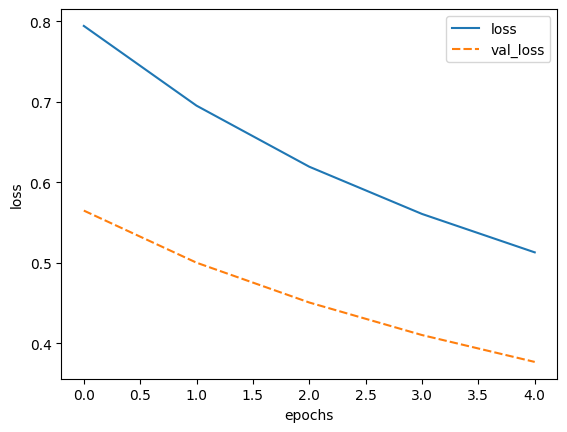

In [14]:
result = pd.DataFrame(history.history)
ax = sns.lineplot(result)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

# Save the training results
plt.savefig(f'results/{identifier}.png')
lasenet.save(f'results/{identifier}_model.keras')

# Hyperparameter tuning

In [17]:
def get_model(parms):
    lasenet = create_model(
        parms["feature_dim"],
        parms["discrete_output_dim"],
        parms["continuous_output_dim"],
        int(parms["units"]),
        parms["dropout"],
        parms["dropout1"],
        parms["dropout2"],
    )
    optimizer = Adam(learning_rate=parms["learning_rate"])
    lasenet.compile(
        loss={
            "continuous_latent": "mse",
        },
        loss_weights={"continuous_latent": 1},
        optimizer=optimizer,
    )
    return lasenet

In [19]:
param_grid = {
  'feature_dim': X_train.shape[-1],
  'continuous_output_dim': 1,
  'discrete_output_dim': 0,
  'units': 36 + hp.randint('units', 200),
  'learning_rate': 3e-4, 
  'dropout': hp.uniform('dropout', .05, .25),
  'dropout1': hp.uniform('dropout1', .01, .1),
  'dropout2': hp.uniform('dropout2', .01, .05),
  'epochs': 25,
  'batch_size': 128,
}

n_iter = 10 # We set it to 10 in our work
kbs = KerasBayesianSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False, n_iter=n_iter, sampling_seed=33)
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
kbs.search(
    X_train,
    y_train,
    trials=Trials(),
    validation_split=0.1,
    callbacks=callbacks)

print(kbs.best_params)
print(kbs.scores)


10 trials detected for ('feature_dim', 'continuous_output_dim', 'discrete_output_dim', 'units', 'learning_rate', 'dropout', 'dropout1', 'dropout2', 'epochs', 'batch_size')

***** (1/10) *****
Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.12492302802998448, 'dropout1': 0.012615786263324952, 'dropout2': 0.026895223609922816, 'epochs': 25, 'feature_dim': 4, 'learning_rate': 0.0003, 'units': np.int32(62)})
SCORE: 0.07177 at epoch 20

***** (2/10) *****
Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.16332624338678303, 'dropout1': 0.06512288262344043, 'dropout2': 0.014747207795025793, 'epochs': 25, 'feature_dim': 4, 'learning_rate': 0.0003, 'units': np.int32(100)})
SCORE: 0.07684 at epoch 25

***** (3/10) *****
Search({'batch_size': 128, 'continuous_output_dim': 1, 'discrete_output_dim': 0, 'dropout': 0.1978495187287711, 'dropout1': 0.08612694583579543, 'dropout2': 0.02194709944897523, 'epochs': 2

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Training with both continuous and discrete latent variables

In [11]:
num_agents = 100
num_trials = 720
model_name = CognitiveModel.HRL2

data_file_path = f'data/hrl/{num_agents}a_{num_trials}t.csv'
data = pd.read_csv(data_file_path)
# extract input features
features = get_onehot_features(data, get_feature_list_by_model(model_name))
# extract labels for supervised learning
q_labels, s_labels = get_labels_by_model(data, model_name)

X_train, X_test, qy_train, qy_test, sy_train, sy_test = train_test_split(
features.numpy(),
q_labels, s_labels,
test_size=0.1,
random_state=33,
)
print(
    X_train.shape,
    X_test.shape,
    qy_train.shape,
    qy_test.shape,
    sy_train.shape,
    sy_test.shape,    
)

(90, 720, 10) (10, 720, 10) (90, 720) (10, 720) (90, 720, 3) (10, 720, 3)


In [13]:
set_seed(33)

## CHANGE ME ##
batch_size = 128
units = 193
dropout = 0.07 
dropout1 = 0.053 
dropout2 =  0.014 
learning_rate = 3e-4
###############

n_agents, n_trial = features.shape[0], features.shape[1]
identifier = f'{model_name.name}_A{n_agents}_{n_trial}t_B{batch_size}_U{units}_D{dropout}_D{dropout1}_D{dropout2}'
print(identifier)

lasenet = create_model(
    feature_dim=X_train.shape[-1],
    continuous_output_dim=1,
    discrete_output_dim=sy_train.shape[-1],
    units=units,
    dropout=dropout,
    dropout1=dropout1,
    dropout2=dropout2,
)

optimizer = Adam(learning_rate=learning_rate)
lasenet.compile(
    loss={
        "discrete_latent": "categorical_crossentropy",
        "continuous_latent": "mse",
    },
    loss_weights={"discrete_latent": 0.2, "continuous_latent": 1},
    optimizer=optimizer,
)

Random seed set as 33
HRL2_A100_720t_B128_U193_D0.07_D0.053_D0.014


In [14]:
callbacks = [EarlyStopping(monitor="val_loss", patience=35, restore_best_weights=True)]
start = time.time()

history = lasenet.fit(
    X_train,
    y={"discrete_latent": sy_train, "continuous_latent": qy_train},
    batch_size=batch_size,
    epochs=5,  # we set to 600 in our work
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_test, {"discrete_latent": sy_test, "continuous_latent": qy_test}),
)

end = time.time()
print(end - start)

Epoch 1/5
1/1 - 4s - loss: 1.0378 - discrete_latent_loss: 1.1093 - continuous_latent_loss: 0.8159 - val_loss: 0.8446 - val_discrete_latent_loss: 1.1068 - val_continuous_latent_loss: 0.6233 - 4s/epoch - 4s/step
Epoch 2/5
1/1 - 1s - loss: 0.8626 - discrete_latent_loss: 1.1097 - continuous_latent_loss: 0.6406 - val_loss: 0.7013 - val_discrete_latent_loss: 1.1072 - val_continuous_latent_loss: 0.4799 - 1s/epoch - 1s/step
Epoch 3/5
1/1 - 1s - loss: 0.7204 - discrete_latent_loss: 1.1112 - continuous_latent_loss: 0.4982 - val_loss: 0.5930 - val_discrete_latent_loss: 1.1090 - val_continuous_latent_loss: 0.3712 - 1s/epoch - 1s/step
Epoch 4/5
1/1 - 1s - loss: 0.6091 - discrete_latent_loss: 1.1138 - continuous_latent_loss: 0.3864 - val_loss: 0.5086 - val_discrete_latent_loss: 1.1121 - val_continuous_latent_loss: 0.2862 - 1s/epoch - 1s/step
Epoch 5/5
1/1 - 1s - loss: 0.5229 - discrete_latent_loss: 1.1174 - continuous_latent_loss: 0.2994 - val_loss: 0.4392 - val_discrete_latent_loss: 1.1159 - val_co

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


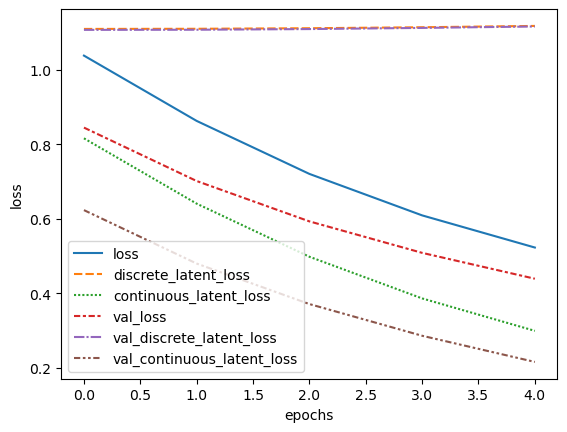

In [15]:
result = pd.DataFrame(history.history)
ax = sns.lineplot(result)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

# Save the training results
plt.savefig(f'results/{identifier}.png')
#lasenet.save(f'results/{identifier}_model')